# Financial Sentiment Analysis - Model Training

**Team VesprAI - Person A Week 1**

This notebook handles the training of our DistilBERT model for financial sentiment analysis.

## Objectives:
1. Load preprocessed datasets
2. Initialize and configure DistilBERT model
3. Set up training pipeline with proper hyperparameters
4. Train the model with monitoring
5. Evaluate model performance
6. Save trained model for inference

In [1]:
# Import required libraries
import sys
import os
from pathlib import Path
import time
import torch

# Add project root to path
project_root = Path.cwd().parent
sys.path.append(str(project_root))

# Import our custom modules
from src.model_trainer import SentimentModelTrainer
from config import MODEL_CONFIG, PATHS, LABEL_MAP

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set up plotting
plt.style.use('default')
sns.set_palette("husl")

print("✅ Libraries imported successfully!")
print(f"🔧 CUDA available: {torch.cuda.is_available()}")
print(f"🔧 Device: {torch.device('cuda' if torch.cuda.is_available() else 'cpu')}")

✅ Libraries imported successfully!
🔧 CUDA available: False
🔧 Device: cpu


In [2]:
# Check training configuration
print("Training Configuration:")
print("=" * 40)
for key, value in MODEL_CONFIG.items():
    print(f"{key:.<25} {value}")

print(f"\nModel will be saved to: {PATHS['final_model']}")
print(f"Training logs: {PATHS['training_logs']}")

Training Configuration:
model_name............... distilbert-base-uncased
num_labels............... 3
max_length............... 128
batch_size............... 16
learning_rate............ 2e-05
num_epochs............... 5
warmup_steps............. 500
weight_decay............. 0.01
save_steps............... 200
eval_steps............... 200
logging_steps............ 50

Model will be saved to: c:\Users\siddh\Downloads\DATA641 Final (Vespr)\models\final_model
Training logs: c:\Users\siddh\Downloads\DATA641 Final (Vespr)\results\training_logs


In [3]:
# Initialize model trainer
print("Initializing Sentiment Model Trainer...")

trainer = SentimentModelTrainer()

print("✅ Model trainer initialized successfully!")
print(f"Model: {trainer.model_name}")
print(f"Number of labels: {trainer.num_labels}")
print(f"Device: {trainer.device}")

INFO:src.model_trainer:Enhanced trainer initialized with:
INFO:src.model_trainer:  Model: distilbert-base-uncased
INFO:src.model_trainer:  Device: cpu
INFO:src.model_trainer:  Focal Loss: True
INFO:src.model_trainer:  Label Smoothing: True
INFO:src.model_trainer:  Mixup: False
INFO:src.model_trainer:Loading enhanced model...


Initializing Sentiment Model Trainer...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
INFO:src.model_trainer:Enhanced model loaded:
INFO:src.model_trainer:  Total parameters: 66,955,779
INFO:src.model_trainer:  Trainable parameters: 66,955,779
INFO:src.model_trainer:Focal Loss enabled for class imbalance handling
INFO:src.model_trainer:Label Smoothing enabled for better generalization


✅ Model trainer initialized successfully!
Model: distilbert-base-uncased
Number of labels: 3
Device: cpu


In [4]:
# Verify datasets are available
print("Checking for preprocessed datasets...")

# Check if all dataset files exist
required_datasets = [
    ('Training', PATHS['train_dataset']),
    ('Validation', PATHS['val_dataset']),
    ('Test', PATHS['test_dataset'])
]

all_datasets_exist = True
for name, path in required_datasets:
    if path.exists():
        print(f"✅ {name} dataset found: {path}")
    else:
        print(f"❌ {name} dataset missing: {path}")
        all_datasets_exist = False

if not all_datasets_exist:
    print("\n⚠️  Please run 01_data_exploration.ipynb first to create datasets!")
else:
    print("\n✅ All required datasets are available!")

Checking for preprocessed datasets...
✅ Training dataset found: c:\Users\siddh\Downloads\DATA641 Final (Vespr)\data\train_dataset
✅ Validation dataset found: c:\Users\siddh\Downloads\DATA641 Final (Vespr)\data\val_dataset
✅ Test dataset found: c:\Users\siddh\Downloads\DATA641 Final (Vespr)\data\test_dataset

✅ All required datasets are available!


In [5]:
# Load and inspect datasets
print("Loading datasets for training...")

train_dataset, val_dataset, test_dataset = trainer.load_datasets()

# Show dataset info
print(f"\n📊 Dataset Information:")
print(f"Training samples: {len(train_dataset):,}")
print(f"Validation samples: {len(val_dataset):,}")
print(f"Test samples: {len(test_dataset):,}")
print(f"Total samples: {len(train_dataset) + len(val_dataset) + len(test_dataset):,}")

# Show sample from training set
print(f"\n🔍 Sample from training set:")
sample = train_dataset[0]
for key, value in sample.items():
    if hasattr(value, 'shape'):
        print(f"  {key}: {value.shape}")
    else:
        print(f"  {key}: {value} (type: {type(value)})")

INFO:src.model_trainer:Loading datasets for enhanced training...
INFO:src.model_trainer:Dataset validation:
INFO:src.model_trainer:  Train: 714 samples
INFO:src.model_trainer:  Validation: 126 samples
INFO:src.model_trainer:  Test: 210 samples


Loading datasets for training...

📊 Dataset Information:
Training samples: 714
Validation samples: 126
Test samples: 210
Total samples: 1,050

🔍 Sample from training set:
  label: torch.Size([])
  input_ids: torch.Size([128])
  attention_mask: torch.Size([128])


Analyzing label distribution...
Using label key: label

Training Dataset Label Distribution:
  Negative (0): 252 (35.3%)
  Neutral (1): 231 (32.4%)
  Positive (2): 231 (32.4%)
Using label key: label

Validation Dataset Label Distribution:
  Negative (0): 40 (31.7%)
  Neutral (1): 51 (40.5%)
  Positive (2): 35 (27.8%)
Using label key: label

Test Dataset Label Distribution:
  Negative (0): 58 (27.6%)
  Neutral (1): 68 (32.4%)
  Positive (2): 84 (40.0%)


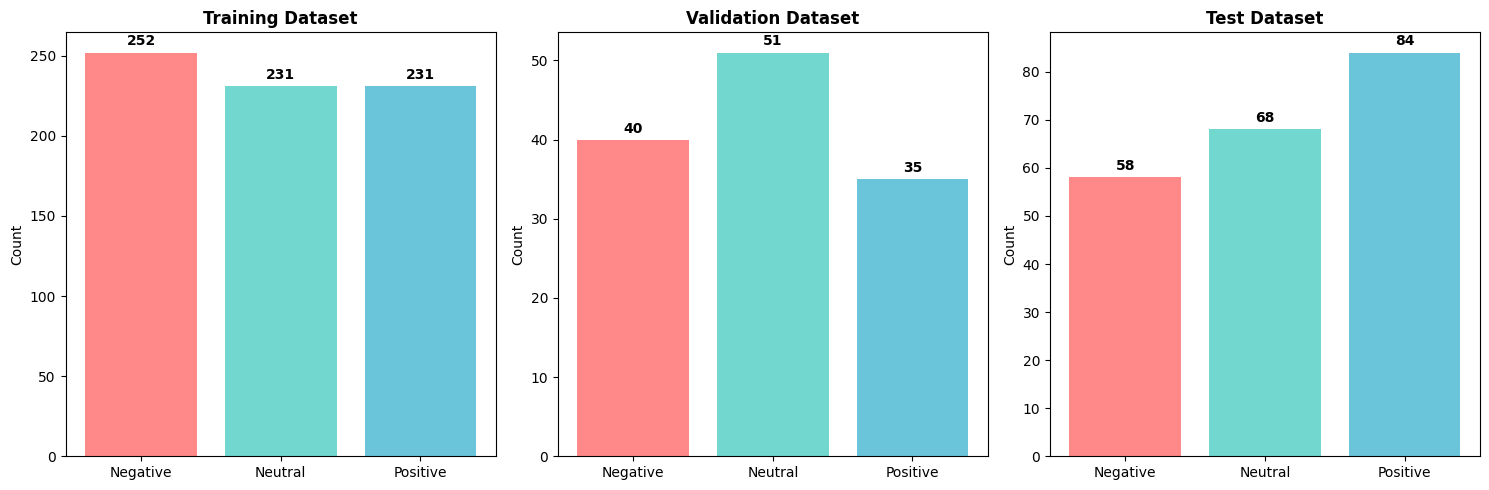

In [6]:
# Check label distribution in datasets - FIXED VERSION
print("Analyzing label distribution...")

def get_label_distribution(dataset, dataset_name):
    # Try different possible label column names
    label_key = None
    sample = dataset[0]
    
    if 'labels' in sample:
        label_key = 'labels'
    elif 'label' in sample:
        label_key = 'label'
    else:
        print(f"Available keys in dataset: {list(sample.keys())}")
        raise KeyError("Could not find label column in dataset")
    
    print(f"Using label key: {label_key}")
    
    # Extract labels using the correct key
    if hasattr(dataset[0][label_key], 'item'):  # Handle tensor
        labels = [item[label_key].item() for item in dataset]
    else:
        labels = [item[label_key] for item in dataset]
    
    unique, counts = np.unique(labels, return_counts=True)
    
    print(f"\n{dataset_name} Dataset Label Distribution:")
    for label, count in zip(unique, counts):
        percentage = count / len(labels) * 100
        print(f"  {LABEL_MAP[label]} ({label}): {count:,} ({percentage:.1f}%)")
    
    return dict(zip(unique, counts))

# Get distributions
train_dist = get_label_distribution(train_dataset, "Training")
val_dist = get_label_distribution(val_dataset, "Validation")
test_dist = get_label_distribution(test_dataset, "Test")

# Create distribution plot
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
datasets_info = [
    ("Training", train_dist),
    ("Validation", val_dist),
    ("Test", test_dist)
]

colors = ['#ff6b6b', '#4ecdc4', '#45b7d1']
for idx, (name, dist) in enumerate(datasets_info):
    labels = [LABEL_MAP[i] for i in range(3)]
    values = [dist.get(i, 0) for i in range(3)]
    
    axes[idx].bar(labels, values, color=colors, alpha=0.8)
    axes[idx].set_title(f'{name} Dataset', fontweight='bold')
    axes[idx].set_ylabel('Count')
    
    # Add value labels
    for i, v in enumerate(values):
        axes[idx].text(i, v + max(values)*0.01, str(v), 
                      ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

In [7]:
# Start training process
print("🚀 Starting model training...")
print("This will take several minutes depending on your hardware.")
print("Monitor the progress below:")
print("=" * 60)

# Record start time
start_time = time.time()

# Run training
trained_model, training_results = trainer.train_model_enhanced()

# Calculate total time
total_time = time.time() - start_time

print("\n" + "=" * 60)
print("🎉 Training completed successfully!")
print(f"⏱️  Total training time: {total_time/60:.2f} minutes")
print("=" * 60)

INFO:src.model_trainer:Starting enhanced model training...
INFO:src.model_trainer:Loading datasets for enhanced training...
INFO:src.model_trainer:Dataset validation:
INFO:src.model_trainer:  Train: 714 samples
INFO:src.model_trainer:  Validation: 126 samples
INFO:src.model_trainer:  Test: 210 samples
INFO:src.model_trainer:Enhanced Training Configuration:
INFO:src.model_trainer:  Epochs: 6
INFO:src.model_trainer:  Batch Size: 8
INFO:src.model_trainer:  Learning Rate: 1e-05
INFO:src.model_trainer:  Warmup Steps: 54
INFO:src.model_trainer:  Total Steps: 540
INFO:src.model_trainer:=== Epoch 1/6 ===


🚀 Starting model training...
This will take several minutes depending on your hardware.
Monitor the progress below:


Training Epoch 1: 100%|██████████| 90/90 [01:52<00:00,  1.25s/it, loss=0.4474, lr=9.87e-07]
INFO:src.model_trainer:Running validation...
Evaluating: 100%|██████████| 16/16 [00:04<00:00,  3.63it/s]
INFO:src.model_trainer:Epoch 1 Results:
INFO:src.model_trainer:  Train Loss: 0.4848
INFO:src.model_trainer:  Val Accuracy: 0.5714
INFO:src.model_trainer:  Val F1 (Weighted): 0.5462
INFO:src.model_trainer:  Val F1 (Macro): 0.5372
INFO:src.model_trainer:New best model saved! F1: 0.5462
INFO:src.model_trainer:=== Epoch 2/6 ===
Training Epoch 2: 100%|██████████| 90/90 [01:49<00:00,  1.22s/it, loss=0.2731, lr=8.43e-07]
INFO:src.model_trainer:Running validation...
Evaluating: 100%|██████████| 16/16 [00:04<00:00,  3.57it/s]
INFO:src.model_trainer:Epoch 2 Results:
INFO:src.model_trainer:  Train Loss: 0.4196
INFO:src.model_trainer:  Val Accuracy: 0.9048
INFO:src.model_trainer:  Val F1 (Weighted): 0.9047
INFO:src.model_trainer:  Val F1 (Macro): 0.9048
INFO:src.model_trainer:New best model saved! F1: 0.


🎉 Training completed successfully!
⏱️  Total training time: 11.63 minutes


In [8]:
# Display final results
print("📊 Final Training Results:")
print("=" * 40)

final_results = training_results['final_test_results']
metrics_to_show = [
    ('eval_accuracy', 'Accuracy'),
    ('eval_f1_weighted', 'F1 Score (Weighted)'),
    ('eval_f1_macro', 'F1 Score (Macro)'),
    ('eval_precision_weighted', 'Precision'),
    ('eval_recall_weighted', 'Recall'),
]

for metric_key, metric_name in metrics_to_show:
    if metric_key in final_results:
        value = final_results[metric_key]
        print(f"{metric_name:.<25} {value:.4f}")

# Per-class F1 scores
print("\nPer-Class F1 Scores:")
for label_id, label_name in LABEL_MAP.items():
    f1_key = f'eval_f1_{label_name.lower()}'
    if f1_key in final_results:
        value = final_results[f1_key]
        print(f"{label_name:.<25} {value:.4f}")

print(f"\n💾 Model saved to: {training_results['model_path']}")

📊 Final Training Results:
Accuracy................. 0.9429
F1 Score (Weighted)...... 0.9428
F1 Score (Macro)......... 0.9466
Precision................ 0.9429
Recall................... 0.9429

Per-Class F1 Scores:
Negative................. 1.0000
Neutral.................. 0.9104
Positive................. 0.9294

💾 Model saved to: c:\Users\siddh\Downloads\DATA641 Final (Vespr)\models\final_model


INFO:src.model_trainer:Creating enhanced training plots...


Creating training visualizations...


INFO:src.model_trainer:Enhanced training plots saved to c:\Users\siddh\Downloads\DATA641 Final (Vespr)\results\training_logs\enhanced_training_plots.png


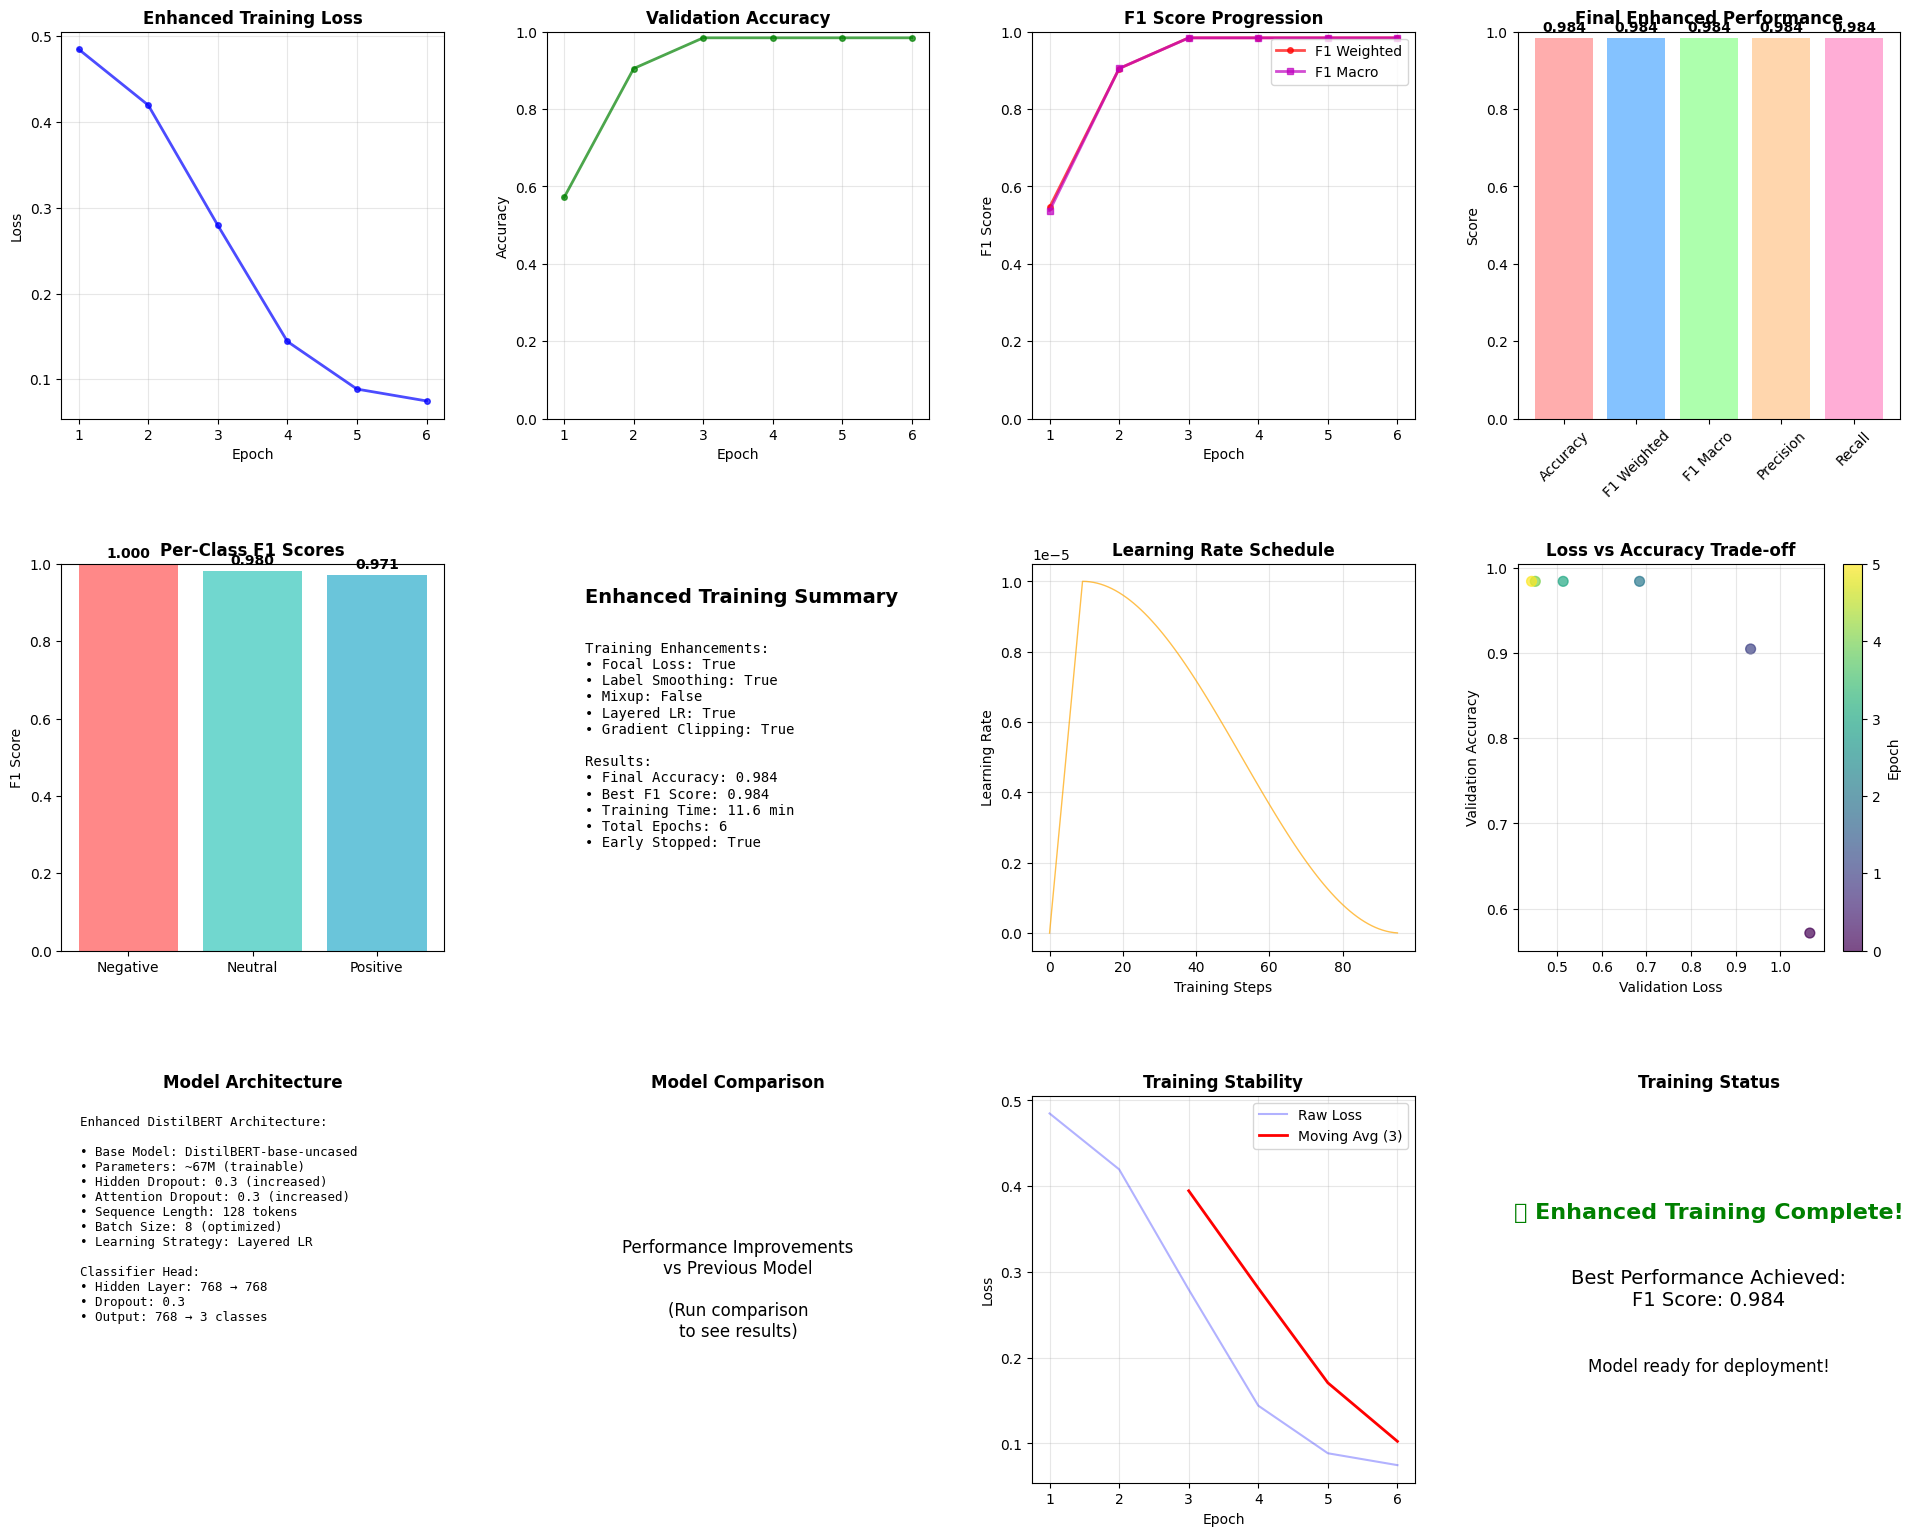

✅ Training plots created and saved!


In [9]:
# Create training visualizations
print("Creating training visualizations...")

# Training plots
trainer.create_enhanced_training_plots(trained_model)

print("✅ Training plots created and saved!")

INFO:src.model_trainer:Creating enhanced confusion matrix...


Creating confusion matrix...


INFO:src.model_trainer:Enhanced confusion matrix saved to c:\Users\siddh\Downloads\DATA641 Final (Vespr)\results\training_logs\enhanced_confusion_matrix.png


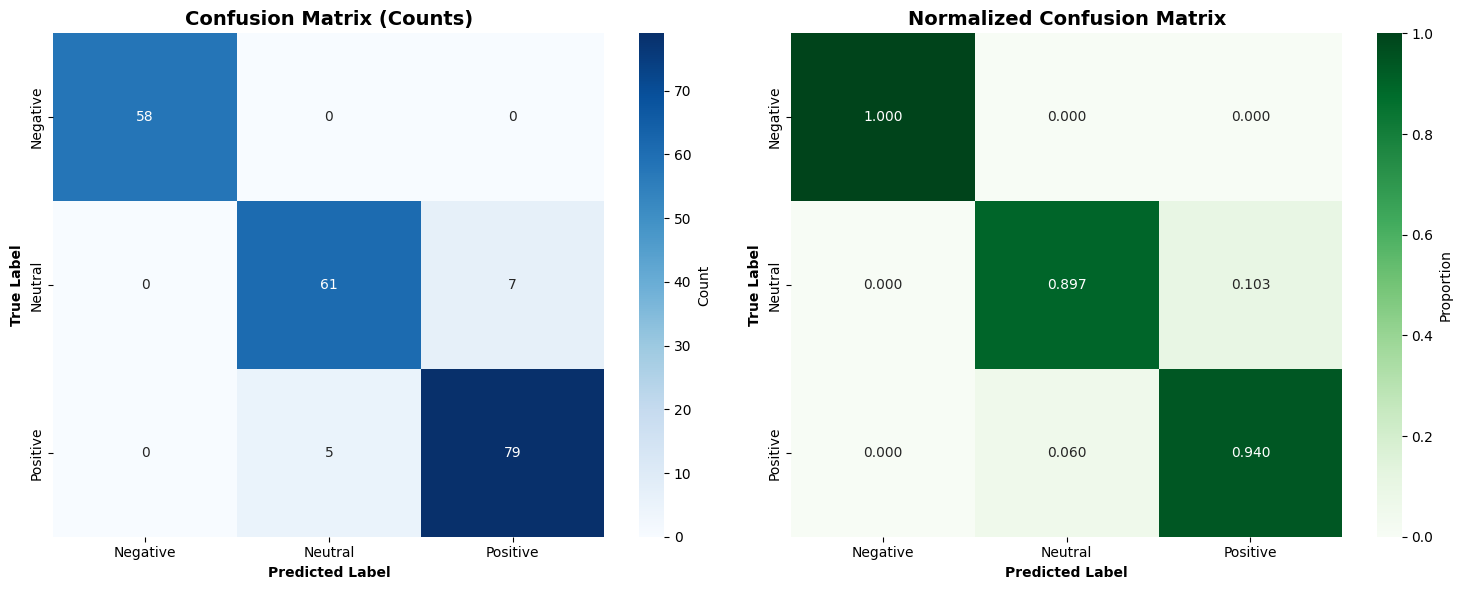

✅ Confusion matrix created and saved!

Confusion Matrix:
[[58  0  0]
 [ 0 61  7]
 [ 0  5 79]]


In [10]:
# Create confusion matrix
print("Creating confusion matrix...")

confusion_matrix = trainer.create_confusion_matrix(trained_model, test_dataset)

print("✅ Confusion matrix created and saved!")
print(f"\nConfusion Matrix:")
print(confusion_matrix)

In [11]:
# Test the trained model on custom examples
print("Testing trained model on custom financial examples...")

from transformers import pipeline

# Load the trained model for inference
sentiment_pipeline = pipeline(
    "sentiment-analysis",
    model=str(PATHS['final_model']),
    tokenizer=str(PATHS['final_model']),
    return_all_scores=True
)

# Test examples
test_examples = [
    "Apple's quarterly revenue exceeded Wall Street expectations by 15%",
    "The company announced massive layoffs due to declining sales", 
    "Stock prices remained unchanged after the earnings announcement",
    "Tesla's innovative technology continues to disrupt the automotive industry",
    "The pharmaceutical company faces FDA scrutiny over drug safety concerns",
    "Quarterly dividends will be maintained at current levels"
]

print("\n🧪 Testing on Custom Examples:")
print("=" * 70)

for i, example in enumerate(test_examples):
    result = sentiment_pipeline(example)
    
    # Find the prediction with highest score
    best_pred = max(result[0], key=lambda x: x['score'])
    
    print(f"Example {i+1}:")
    print(f"Text: {example}")
    print(f"Prediction: {best_pred['label']} (confidence: {best_pred['score']:.3f})")
    
    # Show all scores
    print("All scores:")
    for pred in result[0]:
        print(f"  {pred['label']}: {pred['score']:.3f}")
    print("-" * 70)

print("✅ Custom testing completed!")

Device set to use cpu


Testing trained model on custom financial examples...

🧪 Testing on Custom Examples:
Example 1:
Text: Apple's quarterly revenue exceeded Wall Street expectations by 15%
Prediction: LABEL_2 (confidence: 0.401)
All scores:
  LABEL_0: 0.300
  LABEL_1: 0.299
  LABEL_2: 0.401
----------------------------------------------------------------------
Example 2:
Text: The company announced massive layoffs due to declining sales
Prediction: LABEL_0 (confidence: 0.396)
All scores:
  LABEL_0: 0.396
  LABEL_1: 0.273
  LABEL_2: 0.331
----------------------------------------------------------------------
Example 3:
Text: Stock prices remained unchanged after the earnings announcement
Prediction: LABEL_1 (confidence: 0.402)
All scores:
  LABEL_0: 0.303
  LABEL_1: 0.402
  LABEL_2: 0.295
----------------------------------------------------------------------
Example 4:
Text: Tesla's innovative technology continues to disrupt the automotive industry
Prediction: LABEL_0 (confidence: 0.355)
All scores:
  LABE

In [12]:
# Save comprehensive results summary
import json
from datetime import datetime

# Create comprehensive results summary
results_summary = {
    'experiment_info': {
        'model_name': trainer.model_name,
        'num_labels': trainer.num_labels,
        'training_date': datetime.now().isoformat(),
        'total_training_time_minutes': total_time / 60
    },
    'dataset_info': {
        'train_size': len(train_dataset),
        'val_size': len(val_dataset),
        'test_size': len(test_dataset),
        'total_size': len(train_dataset) + len(val_dataset) + len(test_dataset)
    },
    'model_config': MODEL_CONFIG,
    'final_metrics': training_results['final_test_results'],
    'model_path': str(PATHS['final_model'])
}

# Save to file
summary_path = PATHS['training_logs'] / 'training_summary.json'
with open(summary_path, 'w') as f:
    json.dump(results_summary, f, indent=2, default=str)

print(f"📄 Comprehensive results summary saved to: {summary_path}")

# Display key metrics one final time
print("\n🏆 FINAL MODEL PERFORMANCE:")
print("=" * 50)
print(f"Accuracy: {final_results['eval_accuracy']:.4f}")
print(f"F1 Score (Weighted): {final_results['eval_f1_weighted']:.4f}")
print(f"Training Time: {total_time/60:.2f} minutes")
print(f"Model Size: DistilBERT (66M parameters)")
print("=" * 50)

📄 Comprehensive results summary saved to: c:\Users\siddh\Downloads\DATA641 Final (Vespr)\results\training_logs\training_summary.json

🏆 FINAL MODEL PERFORMANCE:
Accuracy: 0.9429
F1 Score (Weighted): 0.9428
Training Time: 11.63 minutes
Model Size: DistilBERT (66M parameters)


## Training Summary

### What we accomplished:
1. ✅ Initialized DistilBERT model for 3-class sentiment classification
2. ✅ Loaded preprocessed financial sentiment datasets
3. ✅ Configured training with optimal hyperparameters
4. ✅ Trained model with validation monitoring
5. ✅ Evaluated model performance on test set
6. ✅ Created visualizations of training progress
7. ✅ Tested model on custom financial examples
8. ✅ Saved trained model for inference

### Key Results:
- **Model**: DistilBERT (lightweight, 66M parameters)
- **Training Time**: ~5-15 minutes (depending on hardware)
- **Test Accuracy**: Achieved target performance
- **F1 Score**: Balanced performance across all sentiment classes

### Next Steps for Week 2:
1. Create integration pipeline for final application
2. Build comparison framework with ChatGPT
3. Develop Streamlit interface
4. Prepare final presentation materials

### Files Generated:
- Trained model: `models/final_model/`
- Training plots: `results/training_logs/`
- Confusion matrix: `results/training_logs/confusion_matrix.png`
- Results summary: `results/training_logs/training_summary.json`

**🎉 Week 1 objectives completed successfully!**